This notebook details how I figure out trying to align the audio and video.

In [1]:
import os 
import glob 
import warnings
import matplotlib.pyplot as plt
import numpy as np 
plt.rcParams['agg.path.chunksize'] = 10000
import peakutils as peak
import scipy.signal as signal 
import scipy.io.wavfile as WAV


In [2]:
folder = 'Audio_analysis_1tomanybatcontext//'
filenames = glob.glob(folder+'*.WAV')

In [3]:
filenames

['Audio_analysis_1tomanybatcontext/T0000373_1bat.WAV',
 'Audio_analysis_1tomanybatcontext/T0000374_1bat.WAV',
 'Audio_analysis_1tomanybatcontext/T0000364_1bat.WAV',
 'Audio_analysis_1tomanybatcontext/T0000370_1or2bat.WAV',
 'Audio_analysis_1tomanybatcontext/T0000368_1or2bat.WAV',
 'Audio_analysis_1tomanybatcontext/T0000375_1bat.WAV']

In [4]:
# load an example
fs, rec = WAV.read(filenames[4])


/home/tbeleyur/anaconda2/lib/python2.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [5]:
filenames[2]

'Audio_analysis_1tomanybatcontext/T0000364_1bat.WAV'

In [6]:
%matplotlib notebook

And now write this up into a function:

In [7]:
def get_on_off_peaks(sync_signal, fs, video_fps):
    '''Gets the LED flashing signal as recorded in a voltage signal from the Rpi. 
    
    Parameters:
    
        sync_signal : np.array. Voltage signal which is a copy of the LED flashing

        fs : integer. sampling rate of the sync_signal in Hz
    
        video_fps : integer. Recording rate of the video recording that captured the LED. 

    Returns : 

        on_off : np.array. The video frame numbers are which the on-off signal is expected to occur. +1 indicates
                 switching on, and -1 indicates switching off. 
    
    '''
    sync = np.float32(sync_signal.copy())
    sync *= 1.0/np.max(sync)
    # invert the sync signal to get the correct ups and downs : 
    inv_sync = sync * -1 
    
    # isolate the peaks into positive and negative peaks 
    pos_invsync = inv_sync.copy()
    pos_invsync[pos_invsync<0] = 0
    neg_invsync = inv_sync.copy()
    neg_invsync[pos_invsync>0] = 0
    print('Finding peaks')
    # get indices of positive and negative peaks 
    pos_peaks = peak.indexes(pos_invsync, 0.5, 1000)
    neg_peaks = peak.indexes(abs(neg_invsync), 0.5, 1000)
    
    print('calculating indices for video frame rate')
    # calculate indices wrt to video fps 
    pos_peaks_time = pos_peaks/float(fs)
    neg_peaks_time = neg_peaks/float(fs)
    
    pospeaks_vidfps = np.int32(video_fps*pos_peaks_time)
    negpeaks_vidfps = np.int32(video_fps*neg_peaks_time)
    
    # create a binary on/off array to show when the light went on and off:
    rec_duration = sync_signal.size/float(fs)
    rec_samples = int(np.around(video_fps*rec_duration))
    print(rec_samples, video_fps, rec_duration)
    on_off = np.zeros(rec_samples)
    on_off[pospeaks_vidfps] = 1 
    on_off[negpeaks_vidfps] = -1 
    print('Obtained peaks')

    return(on_off)

In [8]:
def get_start_stop(LED_signal, on_off):
    crosscor = np.correlate(LED_signal, on_off, 'same')
    peak_ind = np.argmax(crosscor)
        
    even_numsamples = np.divmod(on_off.size, 2)[1] == 0
    samples_toleftandright = int(on_off.size/2.0)

    if even_numsamples:
        start, stop = peak_ind-samples_toleftandright, peak_ind+samples_toleftandright-1
    else:
        start, stop = peak_ind-samples_toleftandright, peak_ind+samples_toleftandright
    
    return(start, stop, crosscor)   

In [9]:
def align_audio_to_video(LED_signal, fps, audiosync, fs):
    '''
    '''
    on_off = get_on_off_peaks(audiosync, fs, fps)
    audio_start, audio_stop, crosscor = get_start_stop(LED_signal, on_off)
    # check if there's a strong peak
    first_diff = np.diff(crosscor)
    peaks = peak.indexes(first_diff, 0.9)
    
    if len(peaks) >1:
        warnings.warn('There may not be a strong peak !!')
    else:
        print('there might be a peak')
    
    return(audio_start, audio_stop, crosscor)  

In [10]:
all_peaks = get_on_off_peaks(rec[:,3], fs, 25)

Finding peaks
calculating indices for video frame rate
(1501, 25, 60.030976)
Obtained peaks


<IPython.core.display.Javascript object>


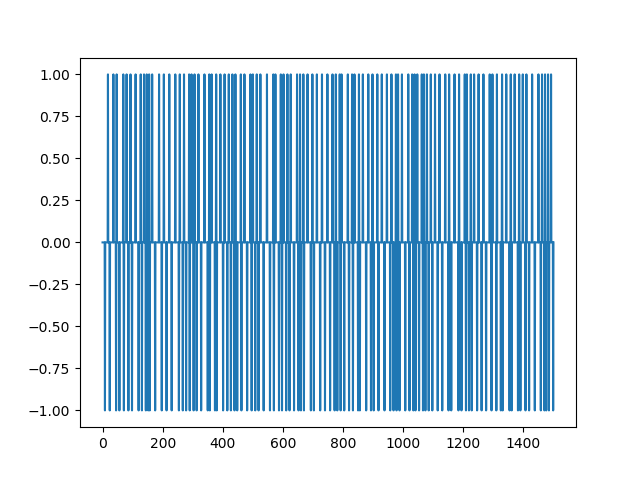

In [20]:
plt.figure()
plt.plot(all_peaks)

And now let's also check that it somehow works :

In [12]:
test_signal = np.concatenate((np.random.choice([1,0,-1],90000,p=[0.3,0.4,0.3]),
                              all_peaks,
                              np.random.choice([1,0,-1],10000,p=[0.3,0.4,0.3])
                              ))

test_signal_null = np.concatenate((np.random.choice([1,0,-1],90000,p=[0.3,0.4,0.3]),
                              np.random.choice([1,0,-1],10000,p=[0.3,0.4,0.3])
                              ))


In [13]:
finddelay = np.correlate(test_signal, all_peaks, 'same')
finddelay_null = np.correlate(test_signal_null, all_peaks, 'same')

<IPython.core.display.Javascript object>


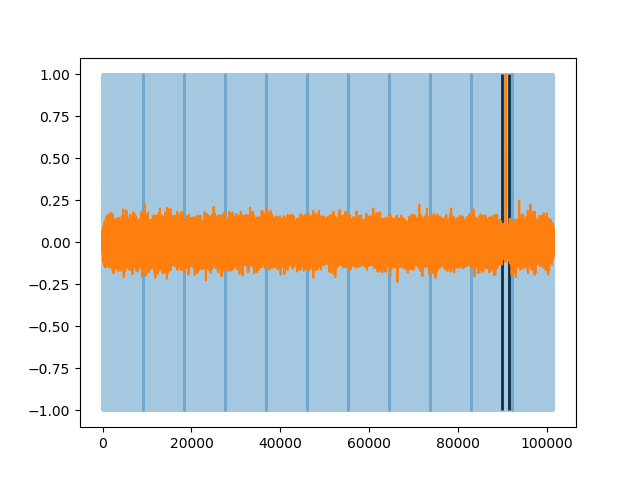

In [17]:
plt.figure()
plt.plot(test_signal,label='test signal', alpha=0.4)
plt.plot(finddelay/np.max(finddelay), label='cross correlation')
midpoint_audiosync = np.argmax(finddelay)
half_audiosync = int(all_peaks.size/2.0)
start, stop, _ = get_start_stop(test_signal, all_peaks)
plt.vlines([start,stop], -1,1, linewidth=2)


###  And now let's just check the final versions of the function in the getting sync peaks module:

In [22]:
from getting_sync_pseaks import align_audio_to_video

In [23]:
start, stop, crosscor = align_audio_to_video(test_signal, 25, rec[:,3], fs)

Finding peaks
calculating indices for video frame rate
(1501, 25, 60.030976)
there might be a peak


In [24]:
start, stop, crosscor = align_audio_to_video(test_signal_null, 25, rec[:,3], fs)

Finding peaks
calculating indices for video frame rate
(1501, 25, 60.030976)


NameError: global name 'warnings' is not defined